Edited version of previous notebook to take out the test set to give the model more data to learn from

In [2]:
import pandas as pd
import mne as mne
import os 
import time
import numpy as np
import matplotlib.pyplot as plt
import joblib
import constants
from IPython.utils import io
import time
import sys
import yasa
from scipy.signal import welch
import random

from scipy.signal import ShortTimeFFT
from scipy.signal.windows import gaussian

#Import my modules
import format_eeg_data
import constants
import eeg_stat_ts

#Pytorch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

/user/home/ko20929/.conda/envs/sktime_latest/lib/python3.11/site-packages/antropy/fractal.py:197: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit((types.Array(types.float64, 1, "C", readonly=True), types.int32))
/user/home/ko20929/.conda/envs/sktime_latest/lib/python3.11/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package yasa is out of date. Your version is 0.6.3, the latest is 0.6.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


#### 1. Load the data

In [3]:
t1 = time.time()

for data_type in ['N1', 'REM' , 'N3' , 'Wake']:
    channels = constants.channel_list
    
    # 1. generate all path names and class list(s) etc. 
    folder = '/user/home/ko20929/work/RBD_using_custom_package/Blue_pebble/'
    paths = joblib.load(folder + data_type + '_paths.pkl') # keys : ['selected_paths', 's_class_list', 's_night_list', 's_sleep_type', 's_p_id']
    
    # 2. Load corresponding data into dataframes, store in dataframe list
    df_list = []
    with io.capture_output() as captured:
        for path in paths['selected_paths']:
            data_epo = mne.read_epochs(path)
            data = data_epo._data * 1e6  # convert signal from V to uV
            df_full = data_epo.to_data_frame()
            df = df_full[channels].copy()
            
            # Do z_score normalisation on the data
            # Got it from here : https://www.geeksforgeeks.org/data-normalization-with-pandas/
            # z_score normalisation __________________
            # copy the data 
            df_z_scaled = df.copy() 

            # apply normalization techniques 
            for column in df_z_scaled.columns: 
                df_z_scaled[column] = (df_z_scaled[column] - df_z_scaled[column].mean()) / df_z_scaled[column].std()

        
            df_list.append(df_z_scaled)
            
    joblib.dump(df_list , data_type + '_normalised_dataframes.pkl')


t2 = time.time()

t2-t1

618.1968195438385

In [3]:
len(df_list)

71

In [4]:
#Took 614 seconds to load the N2 data

In [5]:
# df_list = joblib.load('N2_normalised_dataframes.pkl')

In [6]:
class_label_dict = {'HC': 0 , 'PD' : 1 , 'PD+RBD' : 2 , 'RBD' : 3} #Dictionary used to label the classes for reference
y = np.array([class_label_dict[c_name] for c_name in paths['s_class_list'] ] )
groups = paths['s_p_id']

In [7]:
wake_dfs_binary = []
y_binary = []
groups_binary = []

for df , class_label , group in zip(df_list, y, groups):
    if class_label in [0,1]:
        wake_dfs_binary.append(df)
        y_binary.append(class_label)
        groups_binary.append(group)

y_binary = np.array(y_binary)

In [93]:
#Minimum sample length is 1 minute but the mean is ~ 3 minutes

#### 2. Generate the spectrograms (Prefrontal)

In [8]:
regions = constants.regions
region_channel_dict = constants.region_to_channel_dict
channel_list = constants.channel_list
region_channel_dict['Prefrontal']

['Fp1', 'Fpz', 'Fp2']

In [9]:
#For each dataframe generate a spectrogram
regional_spectrograms = []

for df in wake_dfs_binary:
    
    channel_spectrograms = []
    for channel in region_channel_dict['Prefrontal']:
        
        #for each channel generate a spectrogram, then take the mean of the spectrograms to get the regional spectrogram
           
        eeg_data = df[channel].values 

        # g_std is standard deviation for Gaussian window in samples
        g_std = 200
        w = gaussian(g_std*2, std=g_std, sym=True)  # symmetric Gaussian window of total width 50 samples
        mfft = max(256 , g_std*2)
        
        #Perform STFT 
        SFT = ShortTimeFFT(w, hop=250, fs=256, mfft=mfft, scale_to='magnitude')   
        Sx = SFT.stft(eeg_data)  
        Sx_abs = abs(Sx)
        
        #I can obtain the corresponding frequency values for this spectrogram with 
        frequency_vals = SFT.f
        
        # I want to snip the frequency values to the range I'm interested in 0-40 Hz
        def find_first_above(array, threshold):
            for index, value in enumerate(array):
                if value > threshold:
                    return index
            return -1  # Return -1 if no such value is found
        
        ind = find_first_above(frequency_vals, 40)
        
        frequency_vals = frequency_vals[:ind+1]
        
        #To update the time values I need to input the number of vals in the original sequency 
        num_seq_vals = len(eeg_data)
        time_vals = SFT.t(num_seq_vals)
        
        # snip the spectrogram array to values that are of interest 
        Sx_abs = Sx_abs[:ind+1 , :]

        #Generate the power from the magnitude
        Sx_db = 10*np.log10( np.square(Sx_abs))
        
        channel_spectrograms.append(Sx_db)
        # [Sx_db , time_vals , frequency_vals]
    
    stacked_arrays = np.stack( channel_spectrograms)
    mean_spectrogram = np.mean(stacked_arrays, axis = 0)
    regional_spectrograms.append(mean_spectrogram)

In [10]:
frequency_vals

array([ 0.  ,  0.64,  1.28,  1.92,  2.56,  3.2 ,  3.84,  4.48,  5.12,
        5.76,  6.4 ,  7.04,  7.68,  8.32,  8.96,  9.6 , 10.24, 10.88,
       11.52, 12.16, 12.8 , 13.44, 14.08, 14.72, 15.36, 16.  , 16.64,
       17.28, 17.92, 18.56, 19.2 , 19.84, 20.48, 21.12, 21.76, 22.4 ,
       23.04, 23.68, 24.32, 24.96, 25.6 , 26.24, 26.88, 27.52, 28.16,
       28.8 , 29.44, 30.08, 30.72, 31.36, 32.  , 32.64, 33.28, 33.92,
       34.56, 35.2 , 35.84, 36.48, 37.12, 37.76, 38.4 , 39.04, 39.68,
       40.32])

In [11]:
time_vals[80]

78.125

#### 3. Generate spectrogram slices (for custom time)

(array([450.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 606.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

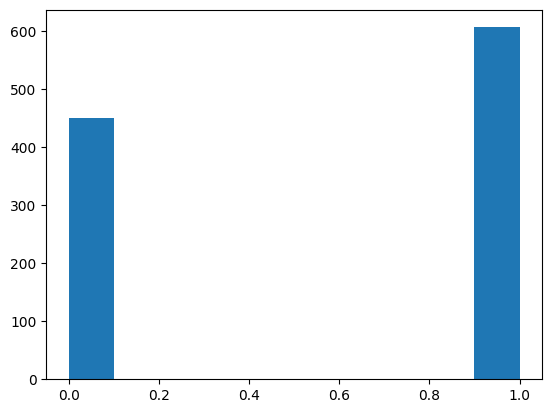

In [12]:
# Generate 30 second slices
# The 157 for 1 minute is derived from the time_vals axis in the spectrogram
segment_length = 80
overlap = 0.6 

spectrogram_slices = []
y_slice_labels = []
y_slice_groups = []

for spectrogram, label, group in zip(regional_spectrograms, y_binary, groups_binary):
    
    num_segments = int( np.floor(spectrogram.shape[1]/segment_length) )
    new_specs = []
    
    for i in np.arange(0,num_segments, 1 - overlap):
        if i > num_segments - 1 :
            # if signal is 4 full minutes, I don't want it to try and take a window from 3.5 minutes to 4.5 minutes
            # will be an incomplete slice causing errors downstream, needs to stop 
            break
          
        start_index = int( np.floor(i*segment_length) )
        end_index = start_index + segment_length
        new_spec = spectrogram[: , start_index : end_index]
        
        spectrogram_slices.append(new_spec)
        y_slice_labels.append(label)
        y_slice_groups.append(group)
        
plt.hist(np.array(y_slice_labels) )

#### 4. Create the CNN

In [13]:
#I want to dynamically change the shape of the CNN according to the size of the input 
spectrogram_slices[0].shape

(64, 80)

In [14]:
# Conv layer
# 64 x 157 ---> 61 x 154
# Max Pool 
# 16 channels ---> 61 / 4 , 154 / 4 ..... 15.25 x 38.5 ... 15 x 38
# Conv layer 15 x 38 ---> 12 x 35 
# Max Pool 15 x 38 ---> 3 x 8 

In [15]:
def out_dim(x):
    '''
    Function to calculate output dimensions for neural network to make it easy for me to define NN for changing window sizes. 
    Action on width and height dim sizes are currently equivalent
    '''
    x = x-3 #convolutional filter of size 4 applied 
    x = int( np.floor(x/4) ) # effect of maxpooling 4 x 4 
    x = x-3 #convolutional filter of size 4 applied
    x = int( np.floor(x/4) ) # effect of maxpooling 4 x 4 
    return x
    
out_dim(157)

8

In [21]:
class AdaptiveConvolutionalNetwork(nn.Module):
    def __init__(self, input_width = 110 , input_height = 64):
        super().__init__()
        self.conv1 = nn.Conv2d(1,12,4,1)
        self.bn1 = nn.BatchNorm2d(12)  # Batch norm after first conv layer
        self.conv2 = nn.Conv2d(12, 30, 4, 1)
        self.bn2 = nn.BatchNorm2d(30)  # Batch norm after second conv layer

        self.out_h = out_dim(input_height) 
        self.out_w = out_dim(input_width)
        
        self.fc1 = nn.Linear(30*self.out_h*self.out_w, int(np.floor( 30*self.out_h*self.out_w / 2) ))
        self.bn3 = nn.BatchNorm1d(int(np.floor( 30*self.out_h*self.out_w / 2) ))

        
        self.fc2 = nn.Linear(int(np.floor( 30*self.out_h*self.out_w / 2) ), 80)
        # self.fc3 = nn.Linear(80,10)
        # self.fc4 = nn.Linear(10,1)
        self.fc3 = nn.Linear(80,1)
        
    def forward(self, X):
        
        X = F.relu(self.bn1(self.conv1(X)))
        X = nn.Dropout2d(p=0.2)(X) # Dropout after first conv layer
        
        X = F.max_pool2d(X,4,4)
        X = F.relu(self.bn2(self.conv2(X)))
        X = nn.Dropout2d(p=0.2)(X) # Dropout after second conv layer

        X = F.max_pool2d(X,4,4)

        
        X = X.view(-1, 30*self.out_h*self.out_w)
        X = F.relu(self.bn3(self.fc1(X) ) )
        X = nn.Dropout(p=0.15)(X) # Dropout after first FC layer
        
        X = F.relu(self.fc2(X))
        X = nn.Dropout(p=0.15)(X) # Dropout after first FC layer
        
        # X = F.relu(self.fc3(X) )
        X = self.fc3(X)
        # X = self.fc4(X) 
        
        
        # return F.log_softmax(X, dim=1 )
        return X

#### 5. Fit the model

##### Trialling splits of the data according to group (participant id)

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GroupKFold

In [18]:
# Function to check the condition
def check_numbers(arr):
    arr = np.unique(arr)
    count_1s = sum(str(num).startswith('1') for num in arr)
    count_4s = sum(str(num).startswith('4') for num in arr)
    
    return count_1s >= 2 and count_4s >= 2

In [19]:
# Train and Validation splits only ----> NO TEST
# spectrogram_slices, y_slice_labels and y_slice_groups to work with
train_val_dict = {}

for value in ['train' , 'val']:
    train_val_dict[value] = {}

X = np.stack(spectrogram_slices)
y = np.array(y_slice_labels)
groups = np.array( [int(group) for group in y_slice_groups] )

gkf = GroupKFold(n_splits = 4) 
fold = 0

for train_index, val_index   in gkf.split(X, y, groups*1):
    fold += 1
    
    X_train, y_train, groups_train  = X[train_index], y[train_index] , groups[train_index]
    X_val, y_val, groups_val =  X[val_index], y[val_index] , groups[val_index]   
    
    train_val_dict['train'][fold] = X_train, y_train, groups_train
    train_val_dict['val'][fold]   = X_val, y_val, groups_val
    
    total_len = len(X) 
    val_percent = 100*(len(X_val) / total_len)
    train_percent = 100*(len(X_train) / total_len)
   
    print('fold ' + str(fold) ) 
    print( str(train_percent)[:3] + ' | '  + str(val_percent)[:3] + ' |' )

    # testing that the splits are as expected
    print( np.unique(groups_train) )
    print( np.unique(groups_val) )
    
    print('__________________________________________________________________________')

#Output from this section of code is X_train, y_train, groups_train AND X_test, y_test, groups_test 

fold 1
75. | 24. |
[1101 1103 1104 1105 1106 1108 1109 1110 1111 1112 1113 1117 1118 1119
 4403 4404 4405 4406 4407 4408 4409]
[1102 1116 4401 4402 4410 4411]
__________________________________________________________________________
fold 2
75. | 24. |
[1101 1102 1103 1105 1106 1108 1109 1110 1112 1113 1116 1118 1119 4401
 4402 4403 4404 4405 4407 4410 4411]
[1104 1111 1117 4406 4408 4409]
__________________________________________________________________________
fold 3
75. | 24. |
[1102 1103 1104 1105 1108 1109 1110 1111 1112 1116 1117 1118 4401 4402
 4406 4407 4408 4409 4410 4411]
[1101 1106 1113 1119 4403 4404 4405]
__________________________________________________________________________
fold 4
74. | 25. |
[1101 1102 1104 1106 1111 1113 1116 1117 1119 4401 4402 4403 4404 4405
 4406 4408 4409 4410 4411]
[1103 1105 1108 1109 1110 1112 1118 4407]
__________________________________________________________________________


##### Fit the model

1
2
3
4

Duration: 40 seconds


<Figure size 640x480 with 0 Axes>

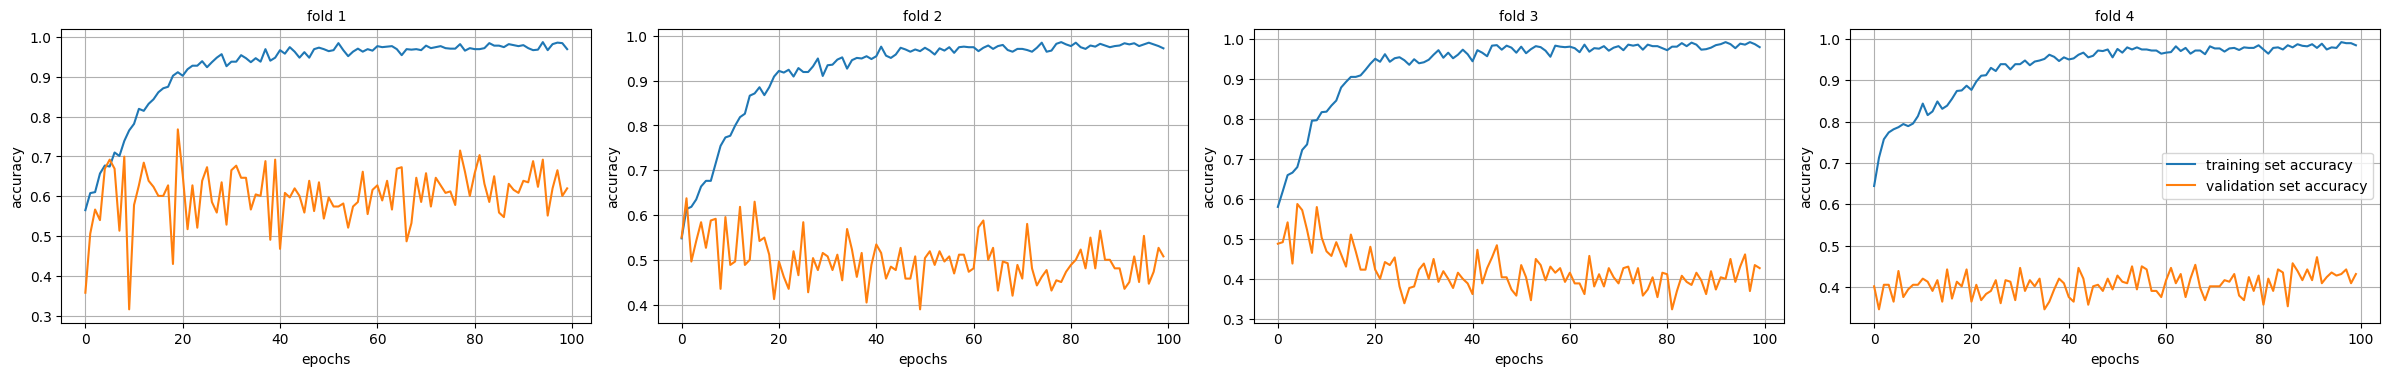

In [23]:
import time
start_time = time.time()

fig = plt.figure()
fig = plt.figure(figsize=(24,14),dpi=100)

# k is for subplots within the overall figure 

k = 1

for fold in [1,2,3,4]:
    print(fold)
    X_train, y_train, groups_train = train_val_dict['train'][fold]
    X_val, y_val, groups_val = train_val_dict['val'][fold]  
    
    # Creating train and test data loaders
    input_width = 80
    train_data = [ (torch.from_numpy(spectrogram).float().view(1,64,input_width), val) for spectrogram, val in zip(X_train, y_train) ] 
    train_loader = DataLoader(train_data, batch_size=30, shuffle=True)
    
    val_data = [ (torch.from_numpy(spectrogram).float().view(1,64,input_width), val) for spectrogram, val in zip(X_val, y_val) ] 
    val_loader = DataLoader(val_data , batch_size=30, shuffle=False)
    
   
    
    
    
    # for seed in [2,5,15,50]:
    for seed in [50]:
        # set all seeds 
        random.seed(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed) 
        
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        # print(device) - to check that device is actually cuda
        
        model = AdaptiveConvolutionalNetwork(input_width = input_width)
        model.to(device)
        
        criterion = nn.BCEWithLogitsLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr = 0.001 )

        epochs = 100
        train_losses = []
        val_losses = []
        test_losses = []
        
        train_correct = []
        val_correct = []
        test_correct = []
        
        for i in range(epochs):
            
            trn_corr = 0
            val_corr = 0
            tst_corr = 0
             
            
            trn_loss = 0
            val_loss = 0
            tst_loss = 0
            
            model.train()
            # Run the training batches
            for b, (X_train_batch, y_train_batch) in enumerate(train_loader):
                b+=1
        
                #Move train data to the GPU
                X_train_batch = X_train_batch.to(device)
                y_train_batch = y_train_batch.to(device)
                
                # Apply the model
                y_pred = model(X_train_batch)  # we don't flatten X-train here
                loss = criterion(y_pred, y_train_batch.unsqueeze(1).float())
         
                # Tally the number of correct predictions
                predicted = torch.round(F.sigmoid(y_pred.detach() ) )
                predicted = predicted.reshape(y_train_batch.shape)
                
                batch_corr = (predicted == y_train_batch).sum()
                trn_corr += batch_corr
                trn_loss += loss
                
                # Update parameters
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
            train_losses.append(trn_loss)
            train_correct.append(trn_corr)
        
            # Run the validation batches
            # Some of the variables in this loop have the same name as the variables in the above loop... be aware of that plz!
            model.eval()
            with torch.no_grad():
                for b, (X_val_batch, y_val_batch) in enumerate(val_loader):
                    b+=1
                    
                    #Move train data to the GPU
                    X_val_batch = X_val_batch.to(device)
                    y_val_batch = y_val_batch.to(device)
        
                    # Apply the model
                    y_val = model(X_val_batch)
        
                    # Tally the number of correct predictions
                    predicted = torch.round(F.sigmoid(y_val.detach() ) )
                    predicted = predicted.reshape(y_val_batch.shape)
                    
                    batch_corr = (predicted == y_val_batch).sum()
                    val_corr += batch_corr
        
                    
                    loss = criterion(y_val, y_val_batch.unsqueeze(1).float())
                    val_loss += loss 
                   
            val_losses.append(val_loss)
            val_correct.append(val_corr)
        
            
           
        
        # Plot the outcome from the loop
        ax = fig.add_subplot(4,4,k)
        k+=1
        plt.title('fold ' + str(fold), fontsize = 10)
        plt.plot([(val.cpu() / len(X_train) ) for val in train_correct], label='training set accuracy')
        plt.plot([(val.cpu()/len(X_val) ) for val in val_correct], label='validation set accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epochs') 
        plt.grid()
    
    
    plt.tight_layout()
        
plt.legend()   
plt.tight_layout()

# plt.savefig('N1_90_sec_50_percent_overlap_hop_200_deeper_network.png')
                
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed       

In [ ]:

for i in range(1,5,1):
    ax = fig.add_subplot(2,2,i)
    plt.plot([(val.cpu() / len(X_train) ) for val in train_correct], label='training set accuracy')
    plt.plot([(val.cpu()/len(X_val) ) for val in val_correct], label='validation set accuracy')
    plt.plot([(val.cpu()/len(X_test) ) for val in test_correct], label='test set accuracy')
    
plt.legend()